 - combinar las tablas
 - limpiar datos
 - combinar las columnas title, brand, summary, description en una nueva columna
 - tokenizar la nueva columnas combinada
 - calcular similitud con la similitud de los items tokenizados del coseno
 - los que son muy similares los eliminamos de la lista
 - agarramos algunos items de la lista y calculamos el mean del overall
 - ordenamos nuevamente descendentemente pero esta vez basados en el overall mean => lista2
 - recomendamos los 10 primeros de la lista 2



In [3]:
import nltk
import json
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
PATH = 'C:/Users/arase/OneDrive/Escritorio/Ara/A-Poli/IIN/7 Semestre/mate aplicada/2023/PROYECT FINAL/Segundo Parcial/AMAZON_FASHION.json.gz'

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(PATH)

In [5]:
PATH = 'C:/Users/arase/OneDrive/Escritorio/Ara/A-Poli/IIN/7 Semestre/mate aplicada/2023/PROYECT FINAL/Segundo Parcial/meta_AMAZON_FASHION.json.gz'

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df_meta = getDF(PATH)

In [6]:
df_meta.shape

(186637, 16)

In [7]:
df_meta['asin'].nunique()

186194

notamos que hay productos que no son unicos, arreglamos eso

In [8]:
df_meta= df_meta.drop_duplicates(subset='asin', keep='first')
df_meta.shape

(186194, 16)

creamos una nueva columnas que contiene la informacion que necesitamos para encontrar items similares

In [9]:
columns_to_combine = ['title', 'brand', 'summary', 'description', 'expliota']
existing_columns = [col for col in columns_to_combine if col in df_meta.columns]

if existing_columns:
    # Al menos una de las columnas en 'existing_columns' existe en el df_metaFrame 'df_meta'.
    # Puedes combinar las columnas existentes y crear la nueva columna 'combined_text'.
    df_meta['combined_text'] = df_meta[existing_columns].apply(lambda row: ' '.join(str(val) for val in row), axis=1)

Text(0, 0.5, 'Count')

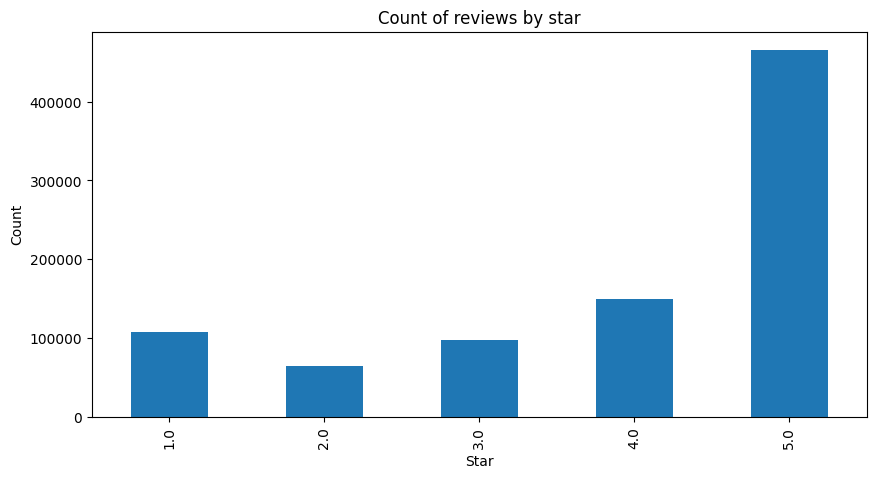

In [10]:
ax = df['overall'].value_counts().sort_index().plot(kind='bar', title="Count of reviews by star",figsize=(10, 5))
ax.set_xlabel("Star")
ax.set_ylabel("Count")


notamos que los reviews estan sesgados hacia 5 estrellas

calculamos el promedio de estrellas por producto y creamos una nueva columna en el df_metaFrame 'df_meta' para almacenar el promedio de estrellas por producto.

In [11]:
# Calcular el "rating score" promedio por 'asin'
rating_score = df.groupby('asin')['overall'].mean().reset_index()

# Renombrar la columna resultante como 'rating_score'
rating_score.rename(columns={'overall': 'rating_score'}, inplace=True)

# Fusionar el DataFrame original con el "rating score" usando 'asin' como clave
df = df.merge(rating_score, on='asin', how='left')

### Tokenizacion de comentarios

In [12]:
example = df['reviewText'][39]
example

'Excellent product!'

In [13]:
nltk.download('punkt')
tokens = nltk.word_tokenize(example)
tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arase\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


['Excellent', 'product', '!']

In [14]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arase\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\arase\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\arase\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping chunkers\maxent_ne_chunker.zip.
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\arase\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

In [15]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Excellent', 'JJ'), ('product', 'NN'), ('!', '.')]

In [16]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S Excellent/JJ product/NN !/.)


In [36]:
overall_mean = df.groupby('asin')['overall'].mean().reset_index()
overall_mean
# num_asin_values = df_meta['asin'].nunique()
# num_asin_values

,asin,overall
0,0764443682,5.000000
1,1291691480,5.000000
2,1940280001,5.000000
3,1940735033,4.857143
4,1940967805,5.000000
...,...,...
186184,B01HJGXL4O,5.000000
186185,B01HJGZVYW,4.000000
186186,B01HJH7JY6,5.000000
186187,B01HJHF97K,3.000000


In [18]:
df_meta['id']=[i for i in range(0,df_meta.shape[0])]

reducimos el tama;o total de las muestras a fin de procesar mas rapido

In [19]:
df_meta_cortado = df_meta.head(1000)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()


In [23]:
vecs = vec.fit_transform(df_meta_cortado['combined_text'].apply(lambda x: np.str_(x)))
vecs.shape

(1000, 4729)

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

In [25]:
sim = cosine_similarity(vecs)
sim

array([[1.        , 0.00457813, 0.05680882, ..., 0.03664615, 0.00384476,
        0.00273318],
       [0.00457813, 1.        , 0.        , ..., 0.        , 0.00984572,
        0.00699916],
       [0.05680882, 0.        , 1.        , ..., 0.02968493, 0.02942811,
        0.        ],
       ...,
       [0.03664615, 0.        , 0.02968493, ..., 1.        , 0.        ,
        0.        ],
       [0.00384476, 0.00984572, 0.02942811, ..., 0.        , 1.        ,
        0.00587797],
       [0.00273318, 0.00699916, 0.        , ..., 0.        , 0.00587797,
        1.        ]])

In [26]:
df_meta_cortado.head(2)

,title,brand,feature,rank,date,asin,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1,combined_text,id
0,Slime Time Fall Fest [With CDROM and Collector...,Group Publishing (CO),[Product Dimensions:\n \n8....,"13,052,976inClothing,Shoesamp;Jewelry(",8.70 inches,0764443682,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Slime Time Fall Fest [With CDROM and Collector...,0
1,XCC Qi promise new spider snake preparing men'...,NaN,NaN,"11,654,581inClothing,Shoesamp;Jewelry(",5 star,1291691480,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XCC Qi promise new spider snake preparing men'...,1


In [96]:
def recommend(asin):
    item_id = df_meta_cortado[df_meta_cortado.asin == asin]['id'].values[0]
    scores = list(enumerate(sim[item_id]))
    sorted_scores= sorted(scores, key=lambda x:x[1], reverse=True)
    sorted_scores=sorted_scores[1:]
    items_selected=[df_meta_cortado[items_selected[0]==df_meta_cortado['id']]['asin'].values[0] for items_selected in sorted_scores]
    return items_selected, sorted_scores

In [97]:
asins, scores = recommend('B0001NLGV8')
print(asins)
print(scores)

for i in range(2):
    print('Item ID: ',scores[i][0])
    print('Similarity Score: ',scores[i][1])
    print('ASIN: ',asins[i])
    print('\n')
    # Busca el 'overall_mean' correspondiente al 'asin'
    overall_mean_item = overall_mean.loc[overall_mean['asin'] == asins[i], 'overall'].values[0]
    print('Overall Mean: ', overall_mean_item)
    print('\n')

['B0001NLH30', 'B0001NLHUS', 'B0001NLH1C', 'B0006U8BPK', 'B00007AV0C', 'B0000BZZEM', 'B0007TBNOG', 'B0000A98WO', 'B0007TBMWO', 'B0000A98NK', 'B0000ANI6K', 'B00023JP38', 'B000AI9VLQ', 'B000685FK6', 'B0000733PM', 'B0007OTTTM', 'B0000BZZEO', 'B000072ZF7', 'B00063W51I', 'B000A87TLA', 'B0007YWT2Q', 'B00024S6LY', 'B000B30W54', 'B000ANNKEK', 'B000072WTB', 'B0009YI1I0', '0764443682', 'B00069472C', 'B0000U0JP6', 'B000078P9Q', 'B000078R4R', 'B000B6A3ZU', 'B0000Z7YJU', 'B0002X9A5G', 'B0002XRP5I', 'B000A89BIE', 'B0006HIYJQ', 'B0002ZG5IE', 'B0000D8VVN', 'B0006SUTQ6', 'B0000U0HBC', 'B0000A98WH', 'B0001NM176', 'B000664B30', 'B00063VPNC', 'B0000WMS7Q', 'B000642UQC', 'B00067IF22', 'B0007KLCZ0', 'B000AG2138', 'B000AYOK6G', 'B0008239W6', 'B0002CU718', 'B00008MN6L', 'B000A6HJV2', 'B0001NM180', 'B0001F2XAY', 'B0002XRP4E', 'B0002PYWRA', 'B0006SUTRK', 'B0001F3NRG', 'B0000BX8MQ', 'B0002PZ5H6', 'B0002PZ5HQ', 'B000AQVC2Y', 'B0006N4YDA', 'B00007GKHE', 'B00020O9DC', 'B0000W3I1G', 'B000A8N1NA', 'B0001F331C', 'B000

In [98]:
top_100_score = scores[:10]
top_100_asin = asins[:10]

print(top_100_asin)
# Crear una lista de tuplas que contenga el ASIN, el score y el overall en el mismo orden
data = list(zip(top_100_asin, top_100_score))

# Crear un DataFrame a partir de los datos combinados
df_result = pd.DataFrame(data, columns=['asin', 'Score'])

# Realizar un join entre df_result y result usando la columna 'ASIN' como clave de unión
final_result = pd.merge(df_result, overall_mean, on='asin')

# Imprimir el resultado final
print(final_result)


['B0001NLH30', 'B0001NLHUS', 'B0001NLH1C', 'B0006U8BPK', 'B00007AV0C', 'B0000BZZEM', 'B0007TBNOG', 'B0000A98WO', 'B0007TBMWO', 'B0000A98NK']
         asin                       Score  overall
0  B0001NLH30  (297, 0.35632088724547323)      4.0
1  B0001NLHUS   (309, 0.3423792970309506)      3.0
2  B0001NLH1C   (298, 0.3343886668301189)      1.0
3  B0006U8BPK  (586, 0.22771284078989293)      5.0
4  B00007AV0C   (59, 0.19598189626488433)      5.0
5  B0000BZZEM  (137, 0.18819810977508622)      5.0
6  B0007TBNOG  (691, 0.18080430618163593)      5.0
7  B0000A98WO   (114, 0.1708513884718601)      4.0
8  B0007TBMWO  (692, 0.17042984371019484)      5.0
9  B0000A98NK  (112, 0.16339388396514157)      5.0


In [65]:
# Realizar un join entre final_result y dataset_original utilizando la columna 'ASIN' como clave de unión
resultado_completo = pd.merge(final_result, df_meta_cortado, on='asin')

# Imprimir el resultado completo
print(resultado_completo)


         asin                       Score  overall  \
0  B0001NLH30  (297, 0.35632088724547323)      4.0   
1  B0001NLHUS   (309, 0.3423792970309506)      3.0   
2  B0001NLH1C   (298, 0.3343886668301189)      1.0   
3  B0006U8BPK  (586, 0.22771284078989293)      5.0   
4  B00007AV0C   (59, 0.19598189626488433)      5.0   
5  B0000BZZEM  (137, 0.18819810977508622)      5.0   
6  B0007TBNOG  (691, 0.18080430618163593)      5.0   
7  B0000A98WO   (114, 0.1708513884718601)      4.0   
8  B0007TBMWO  (692, 0.17042984371019484)      5.0   
9  B0000A98NK  (112, 0.16339388396514157)      5.0   

                                               title brand feature  \
0  Samsonite Umbrellas Mini Flat Lightweight Open...   NaN     NaN   
1  Samsonite Umbrellas Ultra Mini Flat Lightweigh...   NaN     NaN   
2  Samsonite Umbrellas Mini Flat Lightweight Open...   NaN     NaN   
3  OWC Single Cherry Wood Automatic Watch Winder ...  AROA     NaN   
4  Samsonite Business Cases Leather Portfolio (Bl...   